In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from src.preprocess.utils import rename_cols
from src.preprocess.pipeline import preprocess

from src.splits import LeaveOneOutSplitter, GlobalTimeSplitter

from src.stats.base import base_stats, compare_subsets, temporal_stats

from src.stats.temporal import time_counts
from src.stats.plots import plot_inters_px, plot_inters_scatter

# Core and Temporal Statistics

In [2]:
# Load Dataset
movielens = pd.read_csv('data/Movielens-1m/raw.csv')

print(movielens.head())

   user_id  item_id  ratings  timestamp
0        1     1193        5  978300760
1        1      661        3  978302109
2        1      914        3  978301968
3        1     3408        4  978300275
4        1     2355        5  978824291


### Base stats inspection

In [3]:
# Let's start by looking at some basic information about our dataset

base_stats(movielens)

,n_users,n_items,n_interactions,avg_seq_length,density,timeframe
0,6040,3706,1000209,165.597517,0.044684,89750658


In [4]:
# Extended stats give us more info, like interaction percentiles and temporal gaps

base_stats(movielens, extended=True)

,n_users,n_items,n_interactions,avg_seq_length,density,timeframe,max_timestamp,min_timestamp,mean_time_between_interactions,median_time_between_interactions,...,"mean_user_lifetime, %",mean_item_lifetime,median_item_lifetime,"mean_item_lifetime, %",timestamp_collisions,"timestamp_collisions, %",mean_item_occurrence,median_item_occurrence,mean_user_activity,median_user_activity
0,6040,3706,1000209,165.597517,0.044684,89750658,1046454590,956703932,49865.742294,0.0,...,9.145089,6.857192e+07,79996300.0,76.402693,529046,52.893545,269.889099,123.5,165.597517,96.0


### Let's Split our Dataset!

In [5]:
# We'll split the data by time. Older interactions go into training, newer ones go into test.
# This simulates real-world scenarios where we predict future behavior based on past behavior.

splitter = GlobalTimeSplitter(
    quantile=0.9,            # Use 90th percentile of timestamp as cutoff
    remove_cold_users=True,  # Exclude users unseen before validation/test
    target_type="all"        # Use all future interactions
)

# The splitter returns five datasets:
train, validation_input, validation_target, test_input, test_target = splitter.split(movielens)

In [6]:
# Compare statistics between subsets and the original dataset

compare_subsets(
    subsets=[train, validation_target, test_target],
    reference_data=movielens,                                   # reference to compare with
    subset_names=["Train", "Validation Target", "Test Target"], # subset labels
    extended=False,
    return_ref_stats=False,                                     # do not return core stats for the reference
)

n_users           n_items        n_interactions         \
                  Abs. value      % Abs. value      %     Abs. value      %   
Train                 5511.0  91.24     3670.0  99.03       827047.0  82.69   
Validation Target      500.0   8.28      407.0  10.98          500.0   0.05   
Test Target           1180.0  19.54     3405.0  91.88        95812.0   9.58   

                  avg_seq_length           density          timeframe         
                      Abs. value      % Abs. value      %  Abs. value      %  
Train                 150.072038  90.62   0.040892  91.51  21429435.0  23.88  
Validation Target       1.000000   0.60   0.002457   5.50  21392068.0  23.83  
Test Target            81.196610  49.03   0.023846  53.37  68321176.0  76.12

### Temporal diagnostics example

In [7]:
# You can also compute specific metrics from the extended statistics separately - for example, temporal statistics.
temporal_summary_test = temporal_stats(train)

print("\nTest temporal stats:")
print(pd.Series(temporal_summary_test))


Test temporal stats:
max_timestamp                       9.781334e+08
min_timestamp                       9.567039e+08
timeframe                           2.142944e+07
mean_time_between_interactions      7.018125e+03
median_time_between_interactions    0.000000e+00
mean_user_lifetime                  1.046206e+06
median_user_lifetime                3.076000e+03
mean_user_lifetime, %               4.882099e+00
mean_item_lifetime                  1.818664e+07
median_item_lifetime                2.065771e+07
mean_item_lifetime, %               8.486759e+01
timestamp_collisions                4.519710e+05
timestamp_collisions, %             5.464877e+01
dtype: float64


# Repeated Consumption

In [8]:
# Check whether users interact with the same items multiple times

from src.stats.duplicates import get_conseq_duplicates, get_item_repeat, get_all_duplicates, duplicates_stats

In [9]:
## Firstly, let's get duplicate flags

get_item_repeat(train).head() # item repetitions (absent in Movielens-1m)

,user_id,item_id,ratings,timestamp,timestamp_collisions,item_duplicate
3180,24,1784,3,978131551,False,False
3216,24,3707,1,978131551,True,False
3222,24,1968,5,978131551,True,False
3232,24,364,4,978131578,False,False
3262,24,1721,3,978131578,True,False


In [10]:
get_conseq_duplicates(train).head() # no consequtive item repeats either

,user_id,item_id,ratings,timestamp,timestamp_collisions,item_duplicate,conseq_duplicate
3180,24,1784,3,978131551,False,False,False
3216,24,3707,1,978131551,True,False,False
3222,24,1968,5,978131551,True,False,False
3232,24,364,4,978131578,False,False,False
3262,24,1721,3,978131578,True,False,False


In [11]:
# Let's take a look at aggregate statistics

duplicates_stats(train) # as we expected, no duplicates

,Consecutive item duplicates,Non-unique item interactions
Number of Users,0.0,0.0
Share of Users,0.0,0.0
Avg. Number per user,0.0,0.0
Avg. Share per user,0.0,0.0


# Temporal Leakage

In [12]:
# We want to make sure no future interactions "leak" into our training data

from src.stats.leaks import get_leaks, temporal_overlap, find_shared_interactions, leak_counts

In [13]:
# Use Leave-One-Out splitter for this analysis
splitter = LeaveOneOutSplitter()

train, validation_input, validation_target, test_input, test_target = splitter.split(movielens)

In [14]:
# Let's get leakage flags

leak_df = get_leaks(
    data=test_target,           # data to analyze
    reference_data=train,       # data to compare with
    convert_timestamp=False,    # whether to convert timestamp to datetime or not
    )

leak_df.head()

,user_id,item_id,ratings,timestamp,timestamp_collisions,timestamp_ref_max,is_leak
0,1,48,5,978824351.0,False,1.037993e+09,True
1,2,1917,3,978300174.0,True,1.046187e+09,True
2,3,2081,4,978298504.0,False,1.046189e+09,True
3,4,1954,5,978294282.0,True,1.044900e+09,True
4,5,288,2,978246585.0,False,1.043795e+09,True


In [15]:
# Count the number of leaks overall

leak_counts(
    data=test_target, 
    reference_data=train,
    granularity=None        # if granularity is not set, then we count leaks across all dataset
)

{'total_interactions': 6040,
 'leak_interactions': 5901,
 'leak_share': 0.9769867549668875}

In [16]:
leak_counts(
    data=test_target, 
    reference_data=train,
    granularity='y'         # obtain leakage count per year
)

{'total_interactions': timestamp
 2000-12-31    4863
 2001-12-31     590
 2002-12-31     409
 2003-12-31     178
 Freq: A-DEC, Name: item_id, dtype: int64,
 'leak_interactions': timestamp
 2000-12-31    4862
 2001-12-31     589
 2002-12-31     372
 2003-12-31      78
 Freq: A-DEC, Name: is_leak, dtype: int64,
 'leak_share': timestamp
 2000-12-31    0.999794
 2001-12-31    0.998305
 2002-12-31    0.909535
 2003-12-31    0.438202
 Freq: A-DEC, dtype: float64}

In [17]:
# Summary on whether 2 subsets have overlap in time

temporal_overlap(test_target, train)

,reference_start,reference_end,target_start,target_end,overlap_start,overlap_end,overlap_duration_sec,overlap_share_reference,overlap_share_target
0,2000-04-25 23:05:32,2003-02-28 17:49:08,2000-04-26 01:26:28,2003-02-28 17:49:50,2000-04-26 01:26:28,2003-02-28 17:49:08,89742160.0,0.999906,1.0


In [18]:
# If 2 subsets have shared interactions, returns them

find_shared_interactions(test_target, train)

,user_id,item_id,ratings_target,timestamp,timestamp_collisions_target,timestamp_dt_target,ratings_reference,timestamp_collisions_reference,timestamp_dt_reference


# Cold Start

In [19]:
# Check for new users/items in test set that were not seen in training

from src.stats.cold import get_cold, cold_counts, cold_stats

In [20]:
# Let's get back to Global Temporal Split

splitter = GlobalTimeSplitter(
    quantile=0.9,            # Use 90th percentile of timestamp as cutoff
    remove_cold_users=True,  # Exclude users unseen before validation/test
    target_type="all"        # Use all future interactions
)

train, validation_input, validation_target, test_input, test_target = splitter.split(movielens)

In [21]:
# Get flags for cold users

get_cold(
    data=test_target, 
    reference_data=train, 
    col="user_id"
).head()

,user_id,item_id,ratings,timestamp,timestamp_collisions,is_cold
3256,24,468,4,978133414,False,False
3266,24,1584,2,978133665,False,False
3250,24,1633,4,978133782,False,False
3268,24,2023,3,978133782,True,False
3181,24,1788,3,978133814,False,False


In [22]:
# Get flags for cold items

get_cold(
    data=test_target, 
    reference_data=train, 
    col="item_id"
).head()

,user_id,item_id,ratings,timestamp,timestamp_collisions,is_cold
3256,24,468,4,978133414,False,False
3266,24,1584,2,978133665,False,False
3250,24,1633,4,978133782,False,False
3268,24,2023,3,978133782,True,False
3181,24,1788,3,978133814,False,False


In [23]:
cold_stats(
    data=test_target, 
    reference_data=train
)

,Number,Share (by count),Share (by interactions)
Cold Users,92,0.077966,0.062132
Cold Items,29,0.008517,0.000950


In [24]:
# Similar to leekage count, if granularity is not specified, get counts for the whole data

cold_counts(
    data=test_target, 
    reference_data=train
)

{'total_interactions': 95812,
 'cold_interactions': 5953,
 'cold_share': 0.06213209201352649}

In [25]:
# And counts per year

cold_counts(test_target, train, granularity='y')

{'total_interactions': timestamp
 2000-12-31     2137
 2001-12-31    66929
 2002-12-31    23423
 2003-12-31     3323
 Freq: A-DEC, Name: item_id, dtype: int64,
 'cold_interactions': timestamp
 2000-12-31      89
 2001-12-31    2844
 2002-12-31    2696
 2003-12-31     324
 Freq: A-DEC, Name: is_cold, dtype: int64,
 'cold_share': timestamp
 2000-12-31    0.041647
 2001-12-31    0.042493
 2002-12-31    0.115101
 2003-12-31    0.097502
 Freq: A-DEC, dtype: float64}

# Interactions Over Time (and Other Plots)

In [26]:
from src.stats.plots import (
    plot_hist, plot_hist_px,
    plot_inters, plot_inters_scatter
)

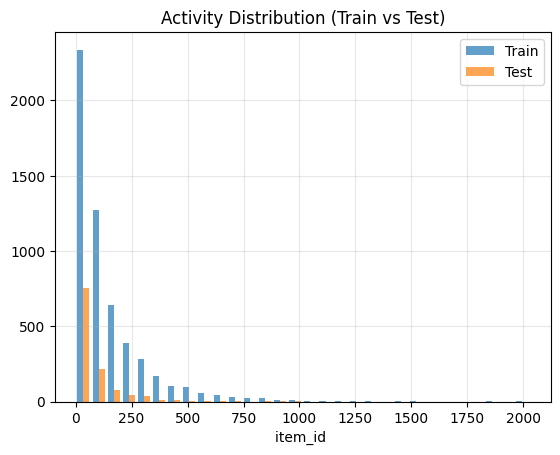

,count,mean,std,min,q01,q05,q25,median,q75,q95,q99,max
Train,5511.0,150.072038,175.521932,2.0,9.1,22.0,41.0,86.0,189.5,506.00,836.90,2029.0
Test,1180.0,81.196610,115.496327,1.0,1.0,2.0,13.0,38.0,102.0,301.05,518.46,1014.0


In [27]:
# Here we compare the distribution of 'item_id' counts for each user - user activity

train_user_interactions = train.groupby('user_id').count()
test_user_interactions = test_target.groupby('user_id').count()

fig, stats = plot_hist(
    data=[train_user_interactions, test_user_interactions],
    col="item_id",
    bins=30,                            # number of histogram bins
    labels=["Train", "Test"],
    color=["#1f77b4", "#ff7f0e"],   # blue/orange colors
    alpha=0.7                           # takes pyplot-specific kwargs!
)

plt.title("Activity Distribution (Train vs Test)")
plt.show()

stats

In [28]:
# Majority of visualization functions have 2 versions: customizable matplotlib version and interactive plotly version.
# To use it, just add _px to the function name. Let's use plot_hist_px, a plotly counterpart of plot_hist.
# Arguments are similar to plot_hist, but the figure is interactive.

fig_px, stats_px = plot_hist_px(
    data=[train_user_interactions, test_user_interactions],
    col="item_id",
    log=False,                  # log-transform for skewed data
    labels=["Train", "Test"],
    nbins=30,                  # number of proposed histogram bins (the ploty may contain less)
    barmode="group",           # overlay bars for comparison (plotly kwarg)
    opacity=0.7
)

# Display interactive plot
fig_px.show()

stats_px

,count,mean,std,min,q01,q05,q25,median,q75,q95,q99,max
Train,5511.0,150.072038,175.521932,2.0,9.1,22.0,41.0,86.0,189.5,506.00,836.90,2029.0
Test,1180.0,81.196610,115.496327,1.0,1.0,2.0,13.0,38.0,102.0,301.05,518.46,1014.0


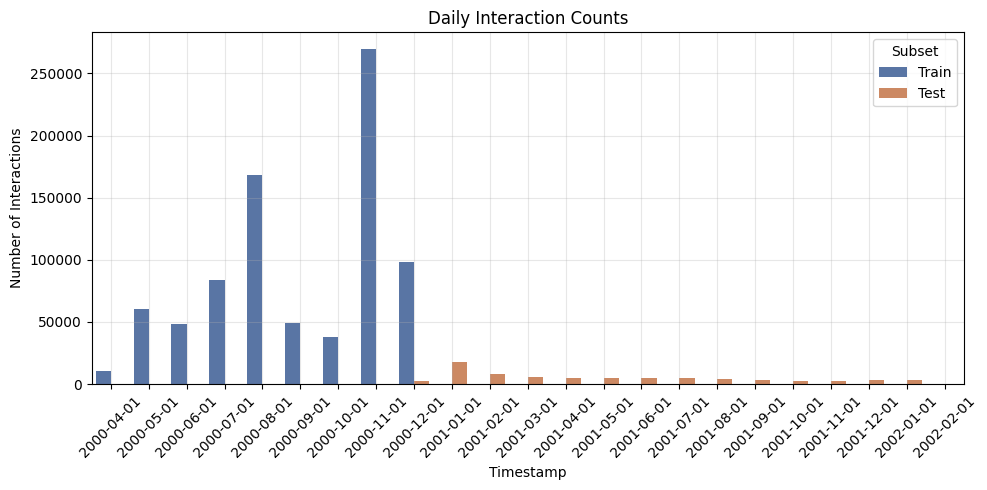

In [29]:
# This function aggregates events into time periods (hours, days, weeks, months)
# and shows how activity changes over time for each subset.

fig = plot_inters(
    data=[train, test_target],
    start_date="01/01/2000",    # optional inclusive start date
    end_date="01/02/2002",      # optional inclusive end date
    granularity="m",            # 'm' = monthly
    labels=["Train", "Test"],
    title="Daily Interaction Counts",
    palette="deep"
)

plt.show()

In [30]:
# Works with plotly!

fig = plot_inters_px(
    data=[train, test_target],
    start_date="01/01/2000",    # optional inclusive start date
    end_date="01/02/2002",      # optional inclusive end date
    granularity="m",            # 'm' = monthly
    labels=["Train", "Test"],
    title="Daily Interaction Counts",
)

fig.show()

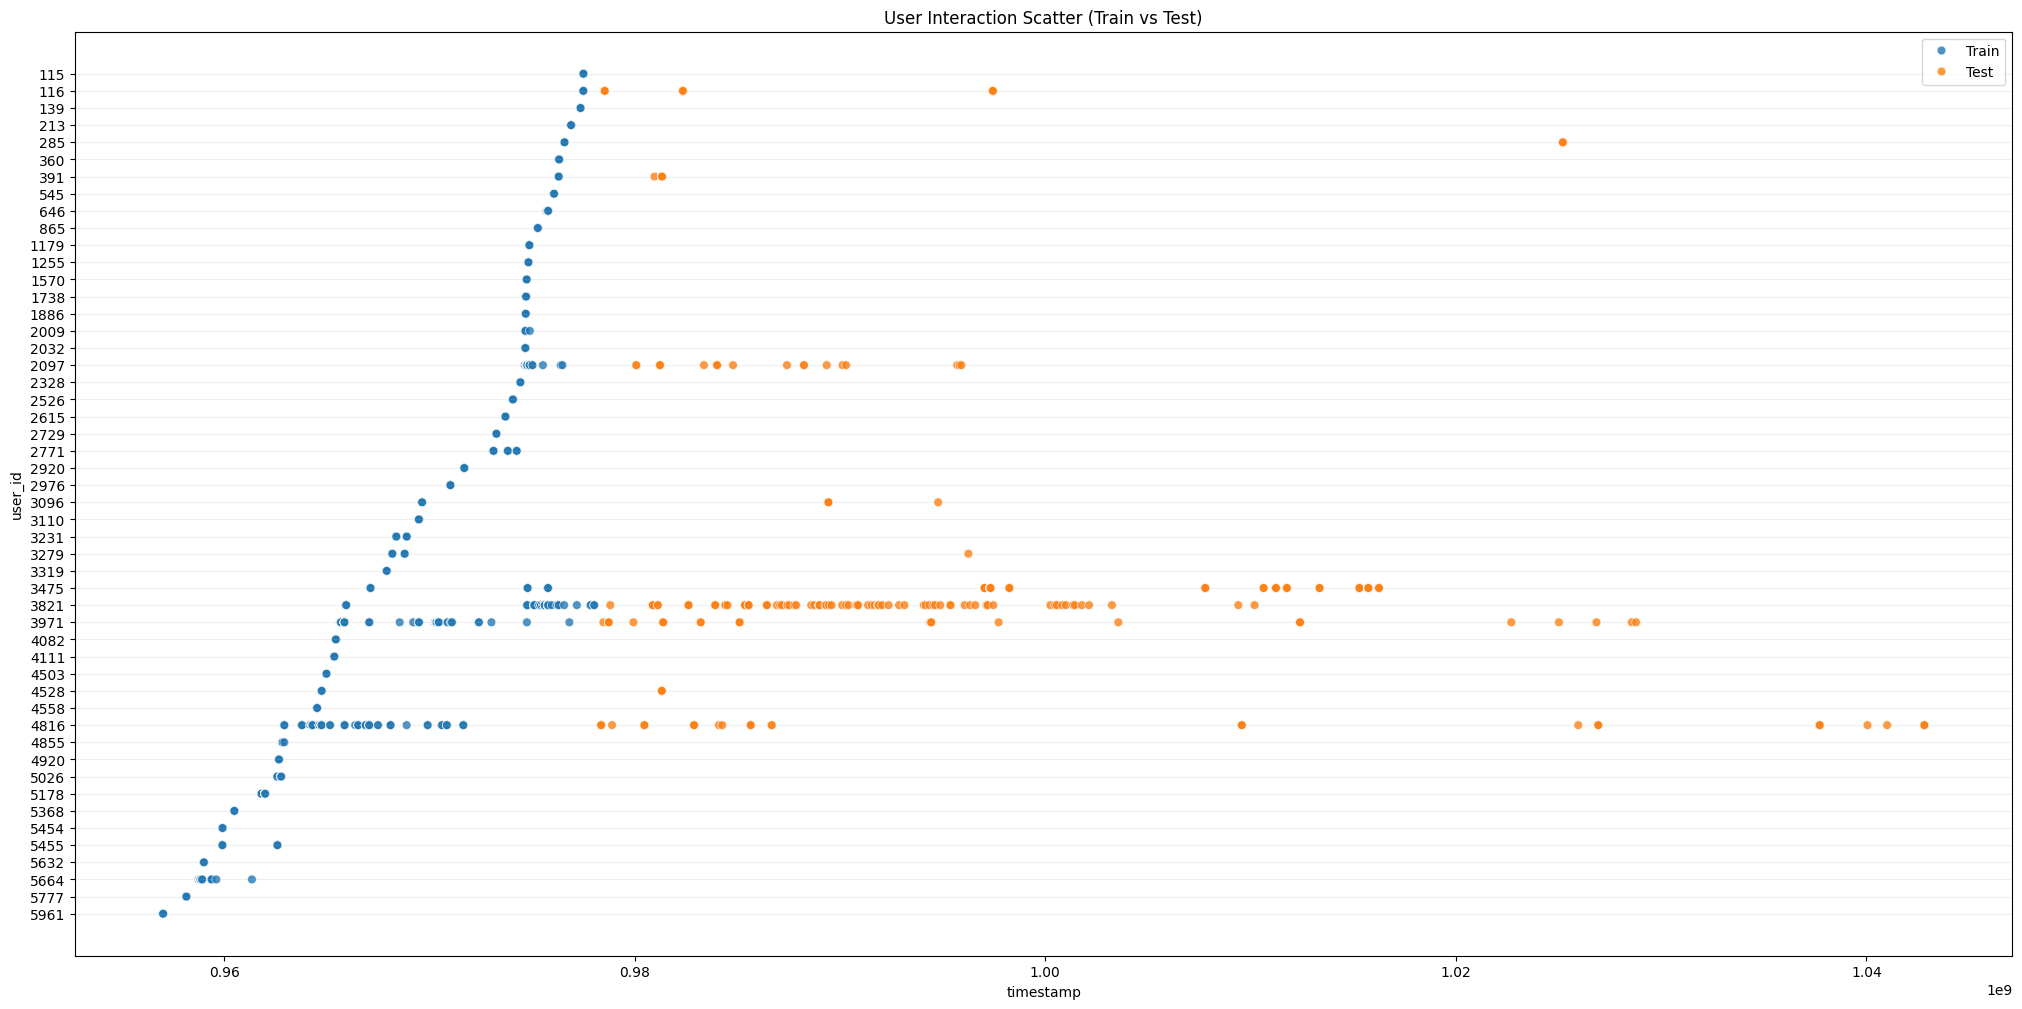

In [31]:
# Let's see, how each individual user history looks for the given split

fig = plot_inters_scatter(
    data=[train, test_target],
    labels=["Train", "Test"],
    users=50,           # sample 50 random users for clarity
    random_state=42,    # reproducible sampling
    point_size=40,      # adjust point size
    alpha=0.8
)

plt.title("User Interaction Scatter (Train vs Test)")
plt.show()